## Curve_fit() doesn't fit well at the tail since the error at the tail is too small. Alter curve_fit() implementation so that Error = (log(1-y')- log(1-y))^2

## Every fitting in this notebook is using new curve_fit()

In [1]:
# Author: Shiqi Jiang
# Last modified: 5/15/2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter
import decimal
import scipy

In [10]:
# All Species and Classes
Species = ["AT", "CE", "DM", "EC", "HS", "MM", "RN", "SC", "SP"]
Classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
functions = [logistic, tanh, arctan, GD, ERF,arctan_GD, Gompertz]      # algebra removed
colors = ['g','r','c','m','y','k','brown','gray']

## Normalization

In [17]:
# combine all classes for one species into one dataframe.
def combine_data(data_location,classes):
    """
    data_location: list containing locations for all classes under one species
    classes: list containing all classes
    
    return: a dataframe for one species with all classes
    """
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb


# return Normalized data_frame for specified species 
def data_frame(species):
    loc = [r"D:\file\Research\P-value\data\{}".format(species) + c for c in Classes]
    df_comb = combine_data(loc,Classes)
    df_class = df_comb['class']
    df_comb = df_comb.drop("class", axis = 1)
    df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
    df_comb['class'] = df_class.reset_index(drop = True)
    return df_comb


# calling data(data_frame, class_name) return Species-Class empirical data as an array, e.g data(df_AT, "ER") -> empirical data: ATER
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

## from Curve_fit() source code 

In [2]:
import warnings
import numpy as np
from numpy import (atleast_1d, dot, take, triu, shape, eye,
                   transpose, zeros, prod, greater,
                   asarray, inf,
                   finfo, inexact, issubdtype, dtype)
from scipy.linalg import svd, cholesky, solve_triangular, LinAlgError, inv
from scipy._lib._util import _asarray_validated, _lazywhere
from scipy._lib._util import getfullargspec_no_self as _getfullargspec
from scipy.optimize._optimize import OptimizeResult, _check_unknown_options, OptimizeWarning
from scipy.optimize._lsq import least_squares
# from ._lsq.common import make_strictly_feasible
from scipy.optimize._lsq.least_squares import prepare_bounds
from scipy.optimize import leastsq

In [3]:
# needed in curve_fit()
def _initialize_feasible(lb, ub):
    p0 = np.ones_like(lb)
    lb_finite = np.isfinite(lb)
    ub_finite = np.isfinite(ub)

    mask = lb_finite & ub_finite
    p0[mask] = 0.5 * (lb[mask] + ub[mask])

    mask = lb_finite & ~ub_finite
    p0[mask] = lb[mask] + 1

    mask = ~lb_finite & ub_finite
    p0[mask] = ub[mask] - 1

    return

def _wrap_jac(jac, xdata, transform):
    if transform is None:
        def jac_wrapped(params):
            return jac(xdata, *params)
    elif transform.ndim == 1:
        def jac_wrapped(params):
            return transform[:, np.newaxis] * np.asarray(jac(xdata, *params))
    else:
        def jac_wrapped(params):
            return solve_triangular(transform, np.asarray(jac(xdata, *params)), lower=True)
    return jac_wrapped

#### curve_fit() call leastsq(f) to do the optimization, where f is the calculation for error returned by _wrap_func()
####  NEW_wrap_func() implementation: f = log(1-y')-log(1-y)

In [4]:
def NEW_wrap_func(func, xdata, ydata, transform):
    if transform is None:
        def func_wrapped(params):
            return np.log(1-func(xdata, *params)) - np.log(1-ydata)
    elif transform.ndim == 1:
        def func_wrapped(params):
            return transform * (np.log(1-func(xdata, *params)) - np.log(1-ydata))
    else:
        # Chisq = (y - yd)^T C^{-1} (y-yd)
        # transform = L such that C = L L^T
        # C^{-1} = L^{-T} L^{-1}
        # Chisq = (y - yd)^T L^{-T} L^{-1} (y-yd)
        # Define (y-yd)' = L^{-1} (y-yd)
        # by solving
        # L (y-yd)' = (y-yd)
        # and minimize (y-yd)'^T (y-yd)'
        def func_wrapped(params):
            return solve_triangular(transform, np.log(1-func(xdata, *params)) - np.log(1-ydata), lower=True)
    return func_wrapped

In [5]:
def curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False,
              check_finite=True, bounds=(-np.inf, np.inf), method=None,
              jac=None, **kwargs):

    
    if p0 is None:
        # determine number of parameters by inspecting the function
        sig = _getfullargspec(f)
        args = sig.args
        if len(args) < 2:
            raise ValueError("Unable to determine number of fit parameters.")
        n = len(args) - 1
    else:
        p0 = np.atleast_1d(p0)
        n = p0.size

    lb, ub = prepare_bounds(bounds, n)
    if p0 is None:
        p0 = _initialize_feasible(lb, ub)

    bounded_problem = np.any((lb > -np.inf) | (ub < np.inf))
    if method is None:
        if bounded_problem:
            method = 'trf'
        else:
            method = 'lm'

    if method == 'lm' and bounded_problem:
        raise ValueError("Method 'lm' only works for unconstrained problems. "
                         "Use 'trf' or 'dogbox' instead.")

    # optimization may produce garbage for float32 inputs, cast them to float64

    # NaNs cannot be handled
    if check_finite:
        ydata = np.asarray_chkfinite(ydata, float)
    else:
        ydata = np.asarray(ydata, float)

    if isinstance(xdata, (list, tuple, np.ndarray)):
        # `xdata` is passed straight to the user-defined `f`, so allow
        # non-array_like `xdata`.
        if check_finite:
            xdata = np.asarray_chkfinite(xdata, float)
        else:
            xdata = np.asarray(xdata, float)

    if ydata.size == 0:
        raise ValueError("`ydata` must not be empty!")

    # Determine type of sigma
    if sigma is not None:
        sigma = np.asarray(sigma)

        # if 1-D, sigma are errors, define transform = 1/sigma
        if sigma.shape == (ydata.size, ):
            transform = 1.0 / sigma
        # if 2-D, sigma is the covariance matrix,
        # define transform = L such that L L^T = C
        elif sigma.shape == (ydata.size, ydata.size):
            try:
                # scipy.linalg.cholesky requires lower=True to return L L^T = A
                transform = cholesky(sigma, lower=True)
            except LinAlgError as e:
                raise ValueError("`sigma` must be positive definite.") from e
        else:
            raise ValueError("`sigma` has incorrect shape.")
    else:
        transform = None

    
    func = NEW_wrap_func(f, xdata, ydata, transform)                           # new_warp_func return the actual f used in leastsq()
    if callable(jac):
        jac = _wrap_jac(jac, xdata, transform)
    elif jac is None and method != 'lm':
        jac = '2-point'

    if 'args' in kwargs:
        # The specification for the model function `f` does not support
        # additional arguments. Refer to the `curve_fit` docstring for
        # acceptable call signatures of `f`.
        raise ValueError("'args' is not a supported keyword argument.")

    if method == 'lm':
        # if ydata.size == 1, this might be used for broadcast.
        if ydata.size != 1 and n > ydata.size:
            raise TypeError(f"The number of func parameters={n} must not"
                            f" exceed the number of data points={ydata.size}")
        # Remove full_output from kwargs, otherwise we're passing it in twice.
        return_full = kwargs.pop('full_output', False)
        res = leastsq(func, p0, Dfun=jac, full_output=1, **kwargs)           # calling leastsq() to solve 
        popt, pcov, infodict, errmsg, ier = res
        ysize = len(infodict['fvec'])
        cost = np.sum(infodict['fvec'] ** 2)
        if ier not in [1, 2, 3, 4]:
            raise RuntimeError("Optimal parameters not found: " + errmsg)
    else:
        # Rename maxfev (leastsq) to max_nfev (least_squares), if specified.
        if 'max_nfev' not in kwargs:
            kwargs['max_nfev'] = kwargs.pop('maxfev', None)

        res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
                            **kwargs)

        if not res.success:
            raise RuntimeError("Optimal parameters not found: " + res.message)

        ysize = len(res.fun)
        cost = 2 * res.cost  # res.cost is half sum of squares!
        popt = res.x

        # Do Moore-Penrose inverse discarding zero singular values.
        _, s, VT = svd(res.jac, full_matrices=False)
        threshold = np.finfo(float).eps * max(res.jac.shape) * s[0]
        s = s[s > threshold]
        VT = VT[:s.size]
        pcov = np.dot(VT.T / s**2, VT)
        return_full = False

    warn_cov = False
    if pcov is None:
        # indeterminate covariance
        pcov = zeros((len(popt), len(popt)), dtype=float)
        pcov.fill(inf)
        warn_cov = True
    elif not absolute_sigma:
        if ysize > p0.size:
            s_sq = cost / (ysize - p0.size)
            pcov = pcov * s_sq
        else:
            pcov.fill(inf)
            warn_cov = True

    if warn_cov:
        warnings.warn('Covariance of the parameters could not be estimated',
                      category=OptimizeWarning)

    if return_full:
        return popt, pcov, infodict, errmsg, ier
    else:
        return popt, pcov


## Helper Functions

In [6]:
# calculating empirical data's Nearest Neighbour(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    """
    data: species-class data, e.g. CEGEO
    
    return: array of Nearest Neighbour distances
    """
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=100)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return


# get factor for this specific empirical data
def get_factor(D):
    """
    D: an array of real data' NN distance
    
    return: factor used in fitting
    """
#     f,ax = plt.subplots(1,1)
#     ax.hist(D,bins=100)
#     ticks = ax.get_xticks()
#     d = min([decimal.Decimal('{:.6g}'.format(t)).as_tuple().exponent for t in ticks])    # temporarily set to 6: max decimal places
#     plt.close(f)
    return np.mean(D)
    

# generate empirical CDF manually, satisfying:
# 1. F(x<=0) = 0
# 2. F(x_1) = 1/(n+1)
# 3. F(x_n/2) = 0.5
# 4. F(x_n) = n/(n+1)
# 5. F(x) < 1 for all x.
def empirical_CDF(data):
    #empirical CDF has added point (0,0)
    '''
    return x,y data of CDF 
    '''    
    sort_data = np.sort(data)
    x = np.concatenate(([0],sort_data))
    y = np.zeros((x.shape))
    for i in range(1,len(x)):
        y[i] = i/len(x)
    
    return x,y


# curve_fit()
def auto_curve_fit_nF(data_NN, x, y,func,p0=None,s=None, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting. Disabled for fitting with binning
    need to scale Xdata with factor so that no erro in np.exp() for small value
    scale back after getting the popt.
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        #p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
        p0 = [np.median(data_NN),1,0.5]
    else:
        #p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
        p0 = [np.median(data_NN),1]
    
    
    #popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')
    popt, pcov = curve_fit(f=func, xdata=x, ydata=y, p0=p0,method='lm')

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt


def auto_curve_fit_F(data_NN, x, y, x_scale_factor, func,s=None, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting. Disabled for fitting with binning
    need to scale Xdata with factor so that no erro in np.exp() for small value
    scale back after getting the popt.
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        p0 = [np.median(data_NN)/x_scale_factor,1,0.5]

    else:
        p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
    
    
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')
    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt

# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class_nF(data, name, func_list, color_list):
    x,y = binning_xy(data)
    
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].set_ylim(bottom=1e-3,top=1.)
    ax[0].scatter(x,1-y, color='b',s=10)
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')                 # xscale log also
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    
    print("For ",name," :")
    for i in range(len(func_list)):
        try:
            if i == 6:
                p = auto_curve_fit_nF(data,x,y,func_list[i],p_control="Gompertz")       # 4.26: weighted s=y disabled for binning
            elif i == 5:
                p = auto_curve_fit_nF(data,x,y,func_list[i],p_control="Weight")
            else:
                p = auto_curve_fit_nF(data,x,y,func_list[i])
        except Exception as e:
            print("error in ",str(func_list[i])[9:-22], " :",e)
            continue
        #y2 = func_list[i](x/factor, *p)
        y2 = func_list[i](x, *p)
        ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
    
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()
    
    # need to decide best fitted sigmoid, using its parameters to construct predictor.
    # return best_func, best_p
    
    

def sigmoids_for_class_F(data, name, factor, func_list, color_list, binning="exp"):
    if binning == "exp":
        x,y = binning_xy(data)
    elif binning == "size":
        x,y = data_binning(data)
    
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].set_ylim(bottom=1e-3,top=1.)
    ax[0].scatter(x,1-y, color='b',s=10)
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')                 # xscale log also
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    
    print("For ",name," :")
    for i in range(len(func_list)):
        try:
            if i == 6:
                p = auto_curve_fit_F(data,x,y,factor,func_list[i],p_control="Gompertz")       # 4.26: weighted s=y disabled for binning
            elif i == 5:
                p = auto_curve_fit_F(data,x,y,factor,func_list[i],p_control="Weight")
            else:
                p = auto_curve_fit_F(data,x,y,factor,func_list[i])
        except RuntimeError:
            print("error in ",str(func_list[i])[9:-22])
            continue
        
        y2 = func_list[i](x/factor, *p)

        ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
    
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()
    
    

def predict(func, popt, factor, data, point, name):
    """
    func: sigmoid to be used in prediction
    popt: parameters for func
    factor: factor for this class
    data: empirical data of a certain class
    point: new data point to be classfied
    name: Species-Class
    
    return: P-value for point belonging to this class
    """
    distances = np.zeros(len(data))
    for i in len(data):
        distances[i] = np.sqrt(np.sum((point-data[i])**2,axis=1))
    
    x = np.min(distances)
    p = 1-func(x/factor, *popt)
    print("Probability for this point belonging to {} = {}".format(name, p))
    
    return p

## Sigmoids

In [7]:
# All Sigmoid functions are rescaled so that range is (0,1)

def logistic(x,x0, k):
    y = (1/ (1 + np.exp(-k*(x-x0))))      
    return y

def tanh(x, x0, k): 
    y = (1+np.tanh(k*(x-x0)))/2
    return y

def arctan(x, x0, k):
    y = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
    return y

def GD(x, x0, k):
    y = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
    return y

def ERF(x, x0, k):
    y = (1+erf(k*(x-x0)))/2
    return y

def algebra(x, x0, k):
    y = (1+x/((1+abs(x)**k)**(1/k)))/2
    return y

def arctan_GD(x,x0,k, w): 
    # a weighted combination of arctan and GD
    y = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return y

def Gompertz(x,b,c):
    y = np.e**(-np.e**(b-c*x))
    return y

## Binning: increasing number of points from largest x-value to small

In [8]:
def binning_xy(data):
    x, y = empirical_CDF(data)   # sorted empirical x,y. First point (0,0)
    # remove leading (0,0) for binning.
    x = x[1:]
    y = y[1:]
    x = np.flip(x)
    y = np.flip(y)             # sorted from largest to smallest
    
    bins = []
    i = 0
    binSize = 1
    while i<len(x):
        if i+binSize > len(x):        # if no enough points for the last bin, merge them into previous one 
            bins[-1] = np.append(bins[-1],np.array(x[i:len(x)]))
            break
        else:
            thisBin = np.array(x[i:i+binSize])
            i += binSize
            bins.append(thisBin)
            binSize *=2
    
    binned_x = []
    binned_y = []
    j = 0
    for b in bins:
        binned_x.append(scipy.stats.mstats.gmean(b))
        binned_y.append(scipy.stats.mstats.gmean(y[j:j+len(b)]))
        j += len(b)
    
    print("small-to-large nBins: ", [len(b) for b in bins[-1::-1]])
    
    binned_x.reverse()
    binned_y.reverse()
    
    return np.array(binned_x), np.array(binned_y)

## Best Sigmoid on original data

In [24]:
def sigmoid_to_ori(data, species, name, factor, func, p_control=None, binning="exp"):
    if binning == "exp":
        binned_x, binned_y = binning_xy(data)
    elif binning == "size":
        binned_x, binned_y = data_binning(data)
    ori_x, ori_y = empirical_CDF(data)
    
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('P-value: Binned '+species+'-'+name)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].scatter(binned_x,1-binned_y, color='r',s=10)

    ax[1].set_title('P-value: Original '+species+'-'+name)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].scatter(ori_x,1-ori_y, color='r',s=10)
    
    p = auto_curve_fit_F(data,binned_x,binned_y,factor,func,p_control=p_control)
    binned_y2 =  func(binned_x/factor, *p)
    ori_y2 = func(ori_x/factor, *p)
    
    print("P-val Error at the furthest tail of Binned Y: ",binned_y2[-1]-binned_y[-1])
    print("P-val Error at the furthest tail of Original Y: ",ori_y2[-1]-ori_y[-1])    # (1-ori_y[-1]) - (1-ori_y2[-1]) = ori_y2[-1]-ori_y1[-1]
    
    ax[0].plot(binned_x, 1-binned_y2, color='b', label=str(func)[9:-22])
    ax[1].plot(ori_x, 1-ori_y2, color='b',label=str(func)[9:-22])
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()
    return

### Fitting on AT

In [18]:
df_AT = data_frame("AT")

In [52]:
distance_ATER = data_distance(data(df_AT,"ER"))

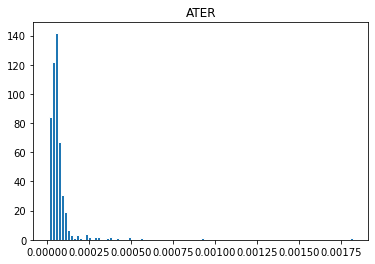

In [91]:
plot_data_distance(distance_ATER,"ATER")

In [92]:
print(np.min(distance_ATER), np.max(distance_ATER))

8.259095602003603e-06 0.0018208266979985804


small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
[0.27657095 0.80815522 0.90481155 0.9529554  0.97698925 0.98899747
 0.9949995  0.998     ]
curve_fit parameter on  arctan :  [5.13137051e-05 5.59177196e+04]


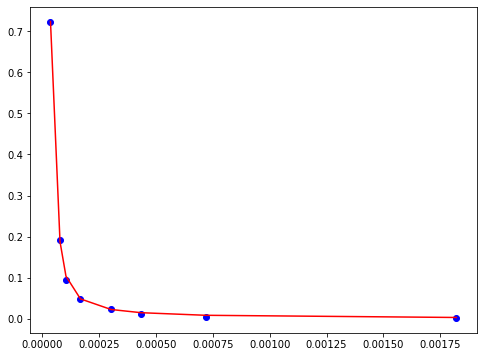

In [63]:
x,y = binning_xy(distance_ATER)
print(y)
p = auto_curve_fit(distance_ATER,x,y,arctan)
y2 = arctan(x, *p)
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(x,1-y,color='b')
ax.plot(x,1-y2,color='r')
plt.show()

## Fitting without Factor

small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
For  ER  :
curve_fit parameter on  logistic :  [-7.82986997e-04  2.70541422e+03]
curve_fit parameter on  tanh :  [-7.82985628e-04  1.35270790e+03]
curve_fit parameter on  arctan :  [5.97012137e-05 7.48232514e+04]
curve_fit parameter on  GD :  [-6.37433891e-04  1.34473544e+03]
curve_fit parameter on  ERF :  [-1.43640042e-03  6.67562634e+02]
error in   arctan_GD   : Optimal parameters not found: Number of calls to function has reached maxfev = 800.
curve_fit parameter on  Gompertz :  [-2.14134590e+00  2.69859203e+03]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


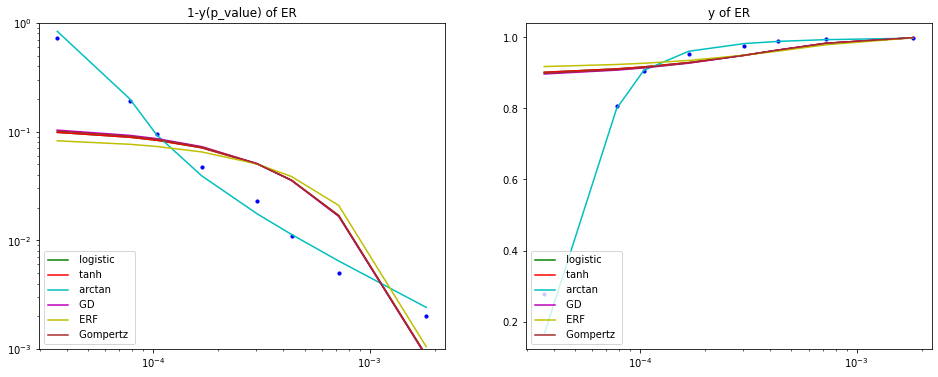

small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
For  ERDD  :
curve_fit parameter on  logistic :  [-2.91749413e-02  4.45787516e+01]
curve_fit parameter on  tanh :  [-0.02917495 22.28938092]
curve_fit parameter on  arctan :  [1.58675079e-02 8.08178950e+02]
curve_fit parameter on  GD :  [-2.07527829e-02  2.20703195e+01]
curve_fit parameter on  ERF :  [-0.06473401 11.33592907]
curve_fit parameter on  arctan_GD :  [9.48237245e-03 7.45884480e+01 9.26415777e-01]
curve_fit parameter on  Gompertz :  [-1.33073141 44.40891626]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


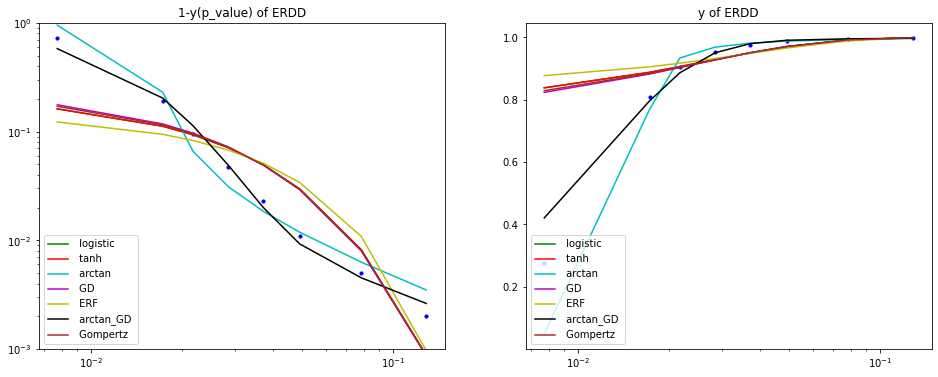

small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
For  GEO  :
curve_fit parameter on  logistic :  [-1.04903508e-03  1.49351329e+03]
curve_fit parameter on  tanh :  [-1.04903581e-03  7.46756485e+02]
curve_fit parameter on  arctan :  [3.17418855e-04 2.92698862e+04]
curve_fit parameter on  GD :  [-7.99639563e-04  7.38958320e+02]
curve_fit parameter on  ERF :  [-2.05302471e-03  3.86070435e+02]
error in   arctan_GD   : Optimal parameters not found: Number of calls to function has reached maxfev = 800.
curve_fit parameter on  Gompertz :  [  -1.59829425 1486.78045348]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


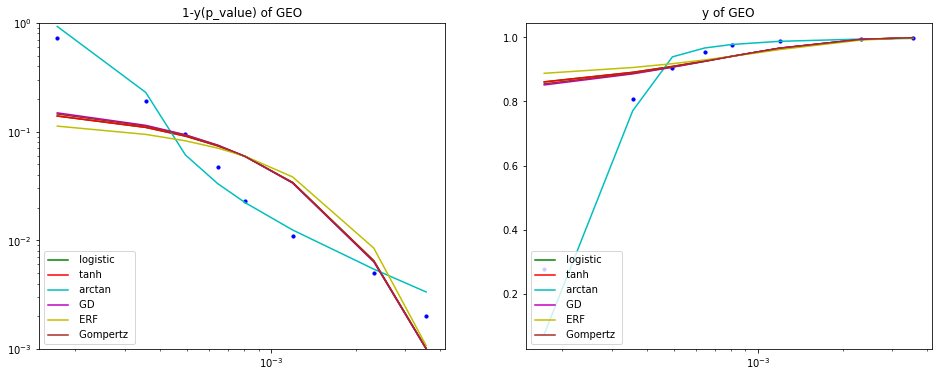

small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
For  GEOGD  :
curve_fit parameter on  logistic :  [-6.47055181e-03  2.00063644e+02]
curve_fit parameter on  tanh :  [-6.47055166e-03  1.00031823e+02]
curve_fit parameter on  arctan :  [7.24820729e-04 2.32269429e+03]
curve_fit parameter on  GD :  [-4.92944451e-03  9.75141989e+01]
curve_fit parameter on  ERF :  [-1.18093229e-02  5.60850499e+01]
curve_fit parameter on  arctan_GD :  [-1.20468165e-03  1.84033808e+02  9.47867027e-01]
curve_fit parameter on  Gompertz :  [ -1.3546089  197.55856729]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


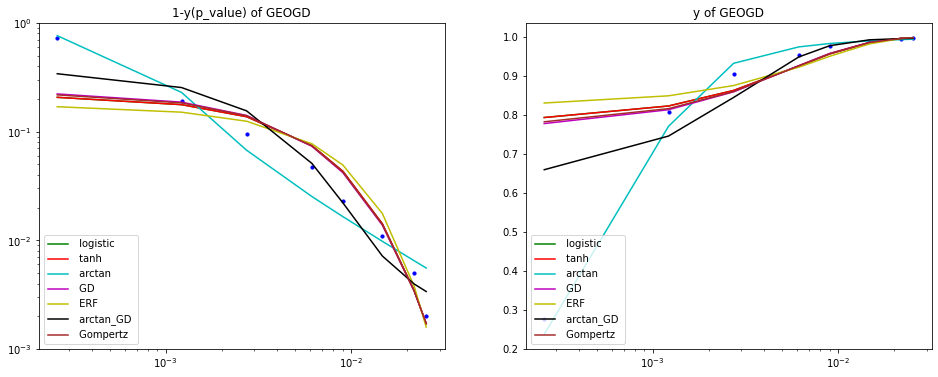

small-to-large nBins:  [188, 32, 16, 8, 4, 2, 1]
For  HGG  :
curve_fit parameter on  logistic :  [0.01053956 7.93283015]
curve_fit parameter on  tanh :  [0.01053782 3.96640183]
curve_fit parameter on  arctan :  [ 0.17103954 62.19728709]
curve_fit parameter on  GD :  [0.0382268  3.77309195]
curve_fit parameter on  ERF :  [-0.06516624  2.47745515]
curve_fit parameter on  arctan_GD :  [0.07513909 5.02887212 0.95052021]
curve_fit parameter on  Gompertz :  [-0.0510958   7.72313585]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


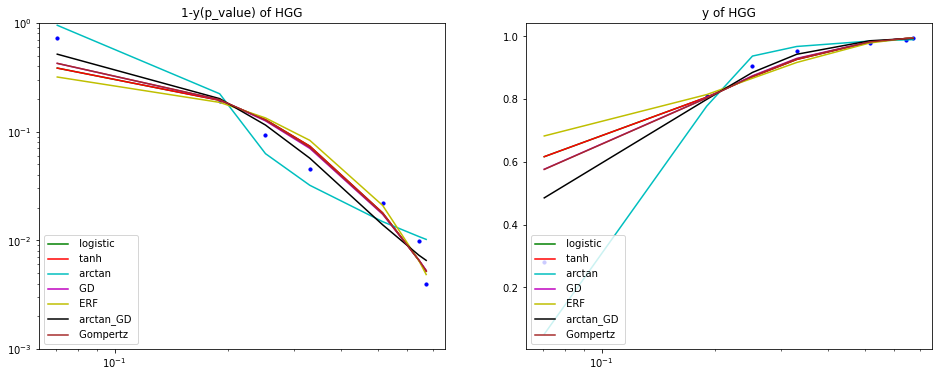

small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
For  SF  :
curve_fit parameter on  logistic :  [-3.96265953e-04  2.74597950e+03]
curve_fit parameter on  tanh :  [-3.96258026e-04  1.37299612e+03]
curve_fit parameter on  arctan :  [3.83055126e-04 5.37399362e+04]
curve_fit parameter on  GD :  [-2.51961748e-04  1.36597763e+03]
curve_fit parameter on  ERF :  [-1.04476379e-03  6.74647198e+02]
error in   arctan_GD   : Optimal parameters not found: Number of calls to function has reached maxfev = 800.
curve_fit parameter on  Gompertz :  [-1.10997634e+00  2.74223411e+03]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


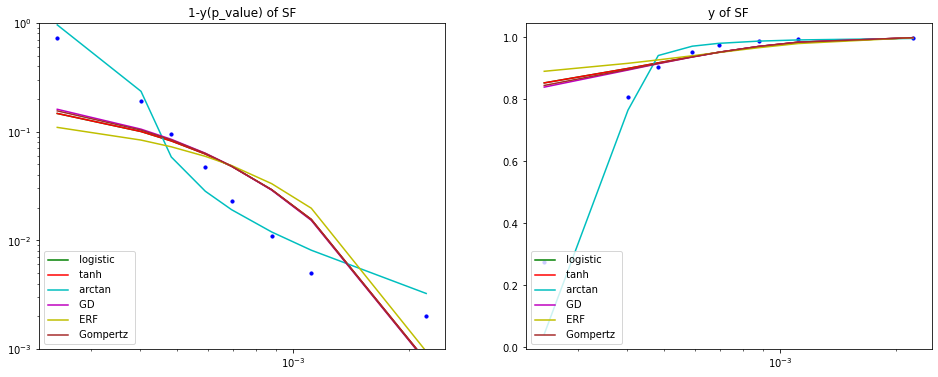

small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
For  SFDD  :
curve_fit parameter on  logistic :  [-0.15833619 10.64800369]
curve_fit parameter on  tanh :  [-0.1583372   5.32399262]
curve_fit parameter on  arctan :  [2.30678091e-02 1.78351345e+02]
curve_fit parameter on  GD :  [-0.12255351  5.27634008]
curve_fit parameter on  ERF :  [-0.31987158  2.64492108]
curve_fit parameter on  arctan_GD :  [1.41357148e-02 2.91736923e+01 8.48732380e-01]
curve_fit parameter on  Gompertz :  [-1.71324733 10.60899064]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


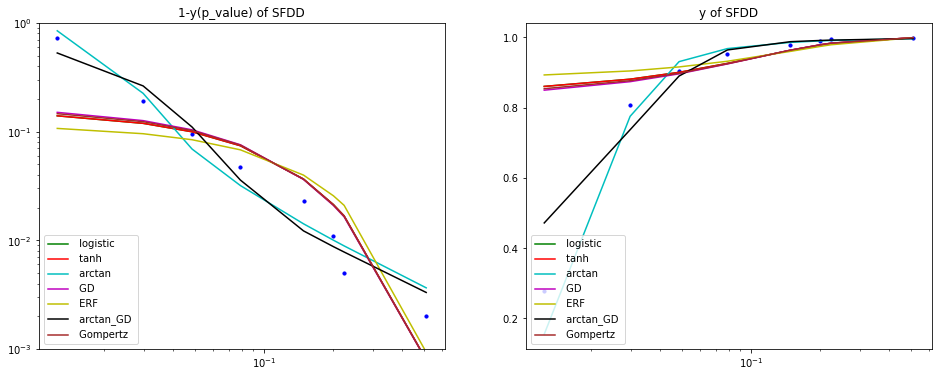

small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
For  Sticky  :
curve_fit parameter on  logistic :  [4.36731749e-03 4.69478065e+02]
curve_fit parameter on  tanh :  [4.36730990e-03 2.34738854e+02]
curve_fit parameter on  arctan :  [7.32637344e-03 4.50930183e+03]
curve_fit parameter on  GD :  [4.90483741e-03 2.25553320e+02]
curve_fit parameter on  ERF :  [2.23752589e-03 1.33569457e+02]
curve_fit parameter on  arctan_GD :  [5.53754827e-03 2.72143103e+02 9.82324784e-01]
curve_fit parameter on  Gompertz :  [  1.88783031 459.13722634]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


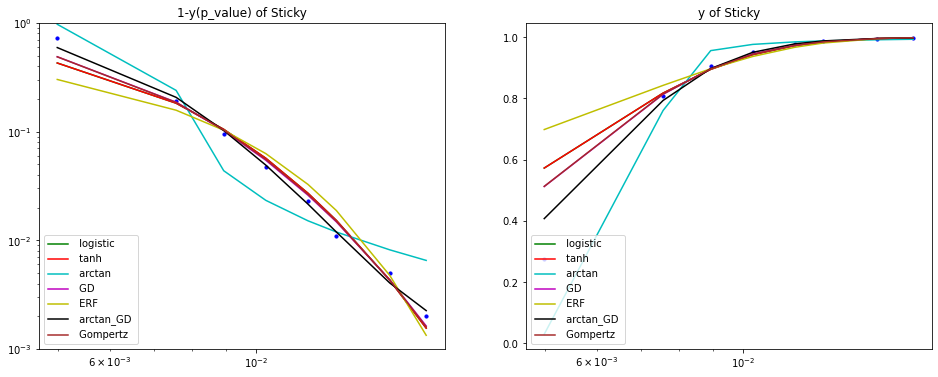

In [19]:
for i in range(len(Classes[:-1])):
    data_i = data_distance(data(df_AT,Classes[:-1][i]))
    sigmoids_for_class_nF(data_i, Classes[:-1][i], functions, colors)

# 5.16 meeting:

# curve_fitting sigmoid to empirical CDF with  Error = (log(1-y')-log(1-y))**2

## Fitting with Factor

Factor for AT-ER: 6.715204121812156e-05
small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
For  ER  :
curve_fit parameter on  logistic :  [-11.6599248    0.18167398]
curve_fit parameter on  tanh :  [0.7063388 1.       ]
curve_fit parameter on  arctan :  [0.88904526 5.02453297]
curve_fit parameter on  GD :  [0.7063388 1.       ]
curve_fit parameter on  ERF :  [0.7063388 1.       ]
curve_fit parameter on  arctan_GD :  [ 0.88244189  6.08740674 -0.21297516]
curve_fit parameter on  Gompertz :  [-2.14134171  0.18121627]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_

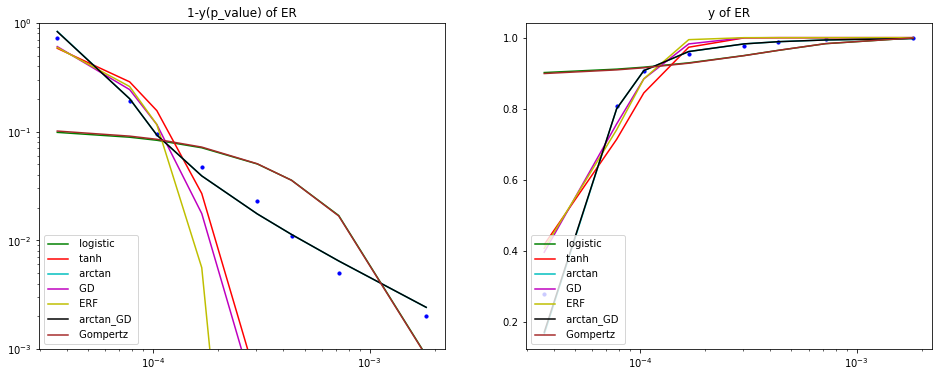

Factor for AT-ERDD: 0.012400372318699539
small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
For  ERDD  :
curve_fit parameter on  logistic :  [-2.35276159  0.55279239]
curve_fit parameter on  tanh :  [-2.35275103  0.27639651]
curve_fit parameter on  arctan :  [ 1.27960073 10.0217465 ]
curve_fit parameter on  GD :  [-1.67357263  0.27367982]
curve_fit parameter on  ERF :  [0.81624829 1.        ]
curve_fit parameter on  arctan_GD :  [0.76468194 0.92492093 0.92641625]
curve_fit parameter on  Gompertz :  [-1.33073218  0.55068696]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


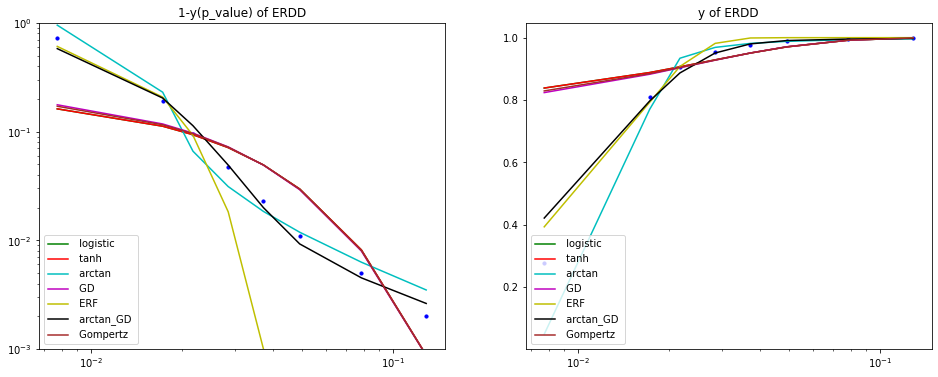

Factor for AT-GEO: 0.0002741471577618578
small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
For  GEO  :
curve_fit parameter on  logistic :  [-3.82657933  0.40944103]
curve_fit parameter on  tanh :  [-3.82654316  0.20472117]
curve_fit parameter on  arctan :  [1.15784298 8.02427833]
curve_fit parameter on  GD :  [-2.91682159  0.20258342]
curve_fit parameter on  ERF :  [0.75766946 1.        ]
curve_fit parameter on  arctan_GD :  [0.78451404 1.0041074  0.89444236]
curve_fit parameter on  Gompertz :  [-1.59829271  0.40759685]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


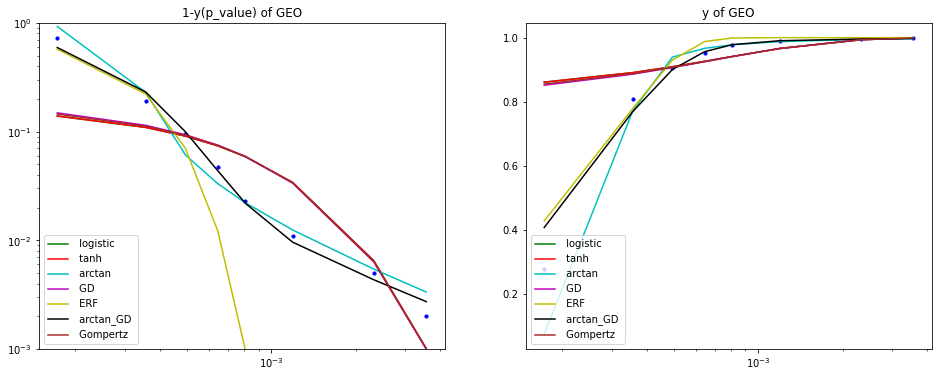

Factor for AT-GEOGD: 0.0011721805161020143
small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
For  GEOGD  :
curve_fit parameter on  logistic :  [-5.52009871  0.2345107 ]
curve_fit parameter on  tanh :  [0.30217549 1.        ]
curve_fit parameter on  arctan :  [0.61835082 2.72261462]
curve_fit parameter on  GD :  [0.30217549 1.        ]
curve_fit parameter on  ERF :  [0.30217549 1.        ]
curve_fit parameter on  arctan_GD :  [ 0.61737669  2.89432205 -0.06299162]
curve_fit parameter on  Gompertz :  [-1.35460814  0.23157435]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_

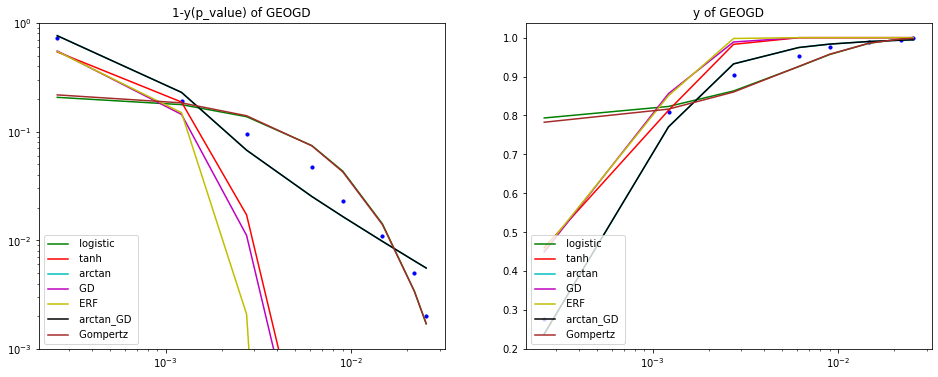

Factor for AT-HGG: 0.12493993663689285
small-to-large nBins:  [188, 32, 16, 8, 4, 2, 1]
For  HGG  :
curve_fit parameter on  logistic :  [0.08434825 0.99112522]
curve_fit parameter on  tanh :  [0.08434302 0.49556199]
curve_fit parameter on  arctan :  [1.36897282 7.77090909]
curve_fit parameter on  GD :  [0.30596594 0.47141042]
curve_fit parameter on  ERF :  [-0.52158625  0.30953273]
curve_fit parameter on  arctan_GD :  [0.60139633 0.6283041  0.95052082]
curve_fit parameter on  Gompertz :  [-0.05109917  0.96492731]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


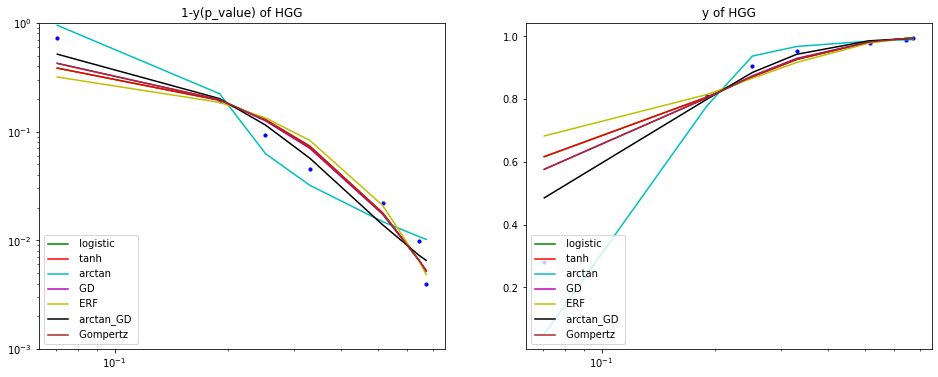

Factor for AT-SF: 0.00031738143836614616
small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
For  SF  :
curve_fit parameter on  logistic :  [-1.24852843  0.87152629]
curve_fit parameter on  tanh :  [-1.24852728  0.43576328]
curve_fit parameter on  arctan :  [ 1.20692158 17.05595098]
curve_fit parameter on  GD :  [-0.79387614  0.43353599]
curve_fit parameter on  ERF :  [0.89158424 1.        ]
curve_fit parameter on  arctan_GD :  [0.88061632 1.45175091 0.9396769 ]
curve_fit parameter on  Gompertz :  [-1.10998133  0.87033314]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


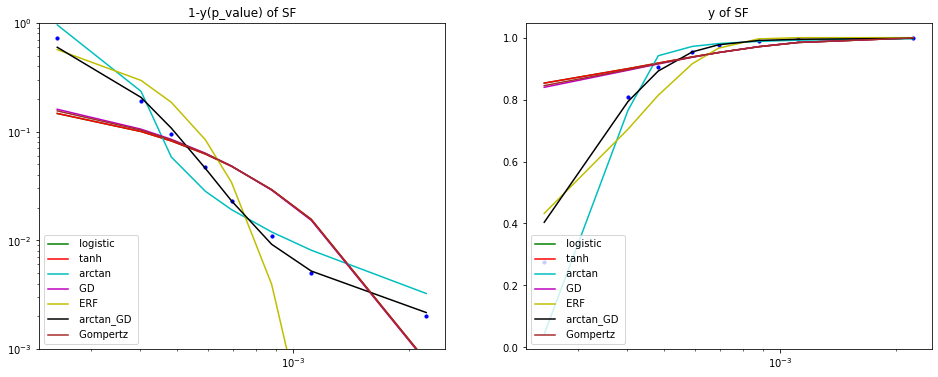

Factor for AT-SFDD: 0.025503546940582315
small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
For  SFDD  :
curve_fit parameter on  logistic :  [-6.2083933   0.27156208]
curve_fit parameter on  tanh :  [0.60853718 1.        ]
curve_fit parameter on  arctan :  [0.90449129 4.54858089]
curve_fit parameter on  GD :  [0.60853718 1.        ]
curve_fit parameter on  ERF :  [0.60853718 1.        ]
curve_fit parameter on  arctan_GD :  [0.55426579 0.74403497 0.84873178]
curve_fit parameter on  Gompertz :  [-1.71324828  0.27056682]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_

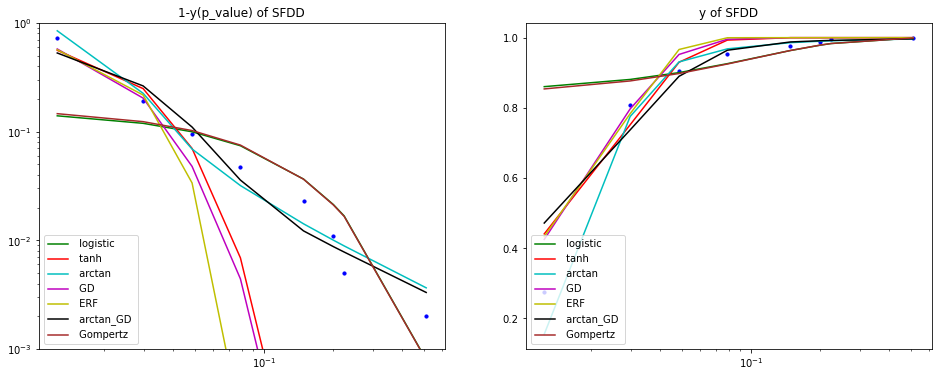

Factor for AT-Sticky: 0.00607303666770087
small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
For  Sticky  :
curve_fit parameter on  logistic :  [0.71913196 2.85115673]
curve_fit parameter on  tanh :  [0.71913241 1.42557876]
curve_fit parameter on  arctan :  [ 1.20637843 27.38531179]
curve_fit parameter on  GD :  [0.8076419  1.36979381]
curve_fit parameter on  ERF :  [0.36843601 0.81117215]
curve_fit parameter on  arctan_GD :  [0.91182549 1.65273554 0.98232477]
curve_fit parameter on  Gompertz :  [1.88782953 2.78835684]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


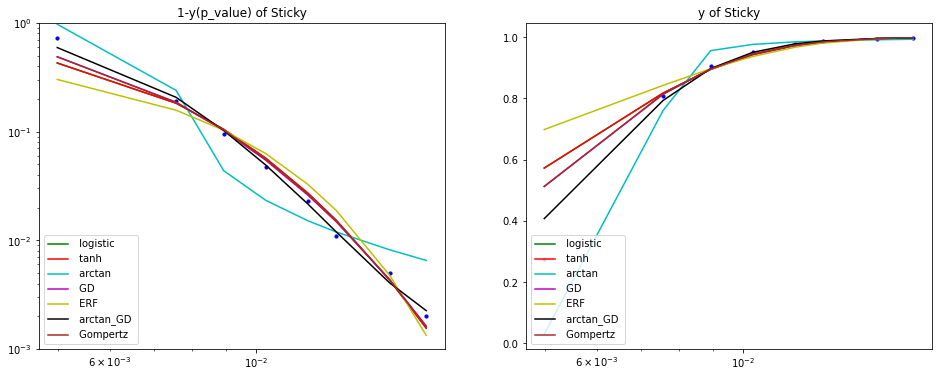

In [20]:
for i in range(len(Classes[:-1])):
    data_i = data_distance(data(df_AT,Classes[:-1][i]))
    factor = get_factor(data_i)
    print("Factor for {}-{}: {}".format("AT",Classes[:-1][i],factor))
    sigmoids_for_class_F(data_i, Classes[:-1][i], factor, functions, colors, "exp")

### arctan_GD vs original AT, fitting with factor

small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
curve_fit parameter on  arctan_GD :  [ 0.88244189  6.08740674 -0.21297516]
P-val Error at the furthest tail of Binned Y:  -0.0004178180545973964
P-val Error at the furthest tail of Original Y:  -0.0004178180545973964


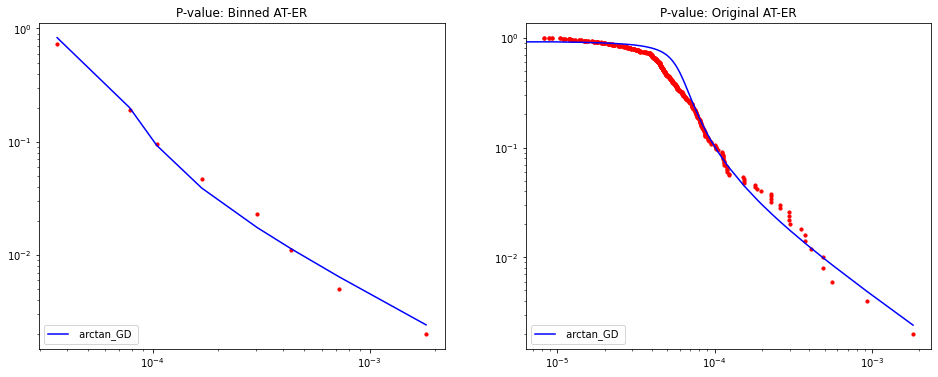

small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
curve_fit parameter on  arctan_GD :  [0.76468194 0.92492093 0.92641625]
P-val Error at the furthest tail of Binned Y:  -0.0006282398218798724
P-val Error at the furthest tail of Original Y:  -0.0006282398218798724


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


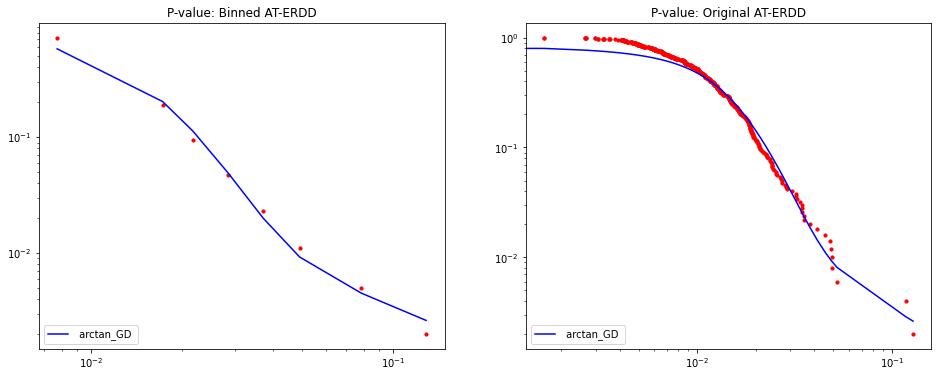

small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
curve_fit parameter on  arctan_GD :  [0.78451404 1.0041074  0.89444236]
P-val Error at the furthest tail of Binned Y:  -0.0007296959434652805
P-val Error at the furthest tail of Original Y:  -0.0007296959434652805


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


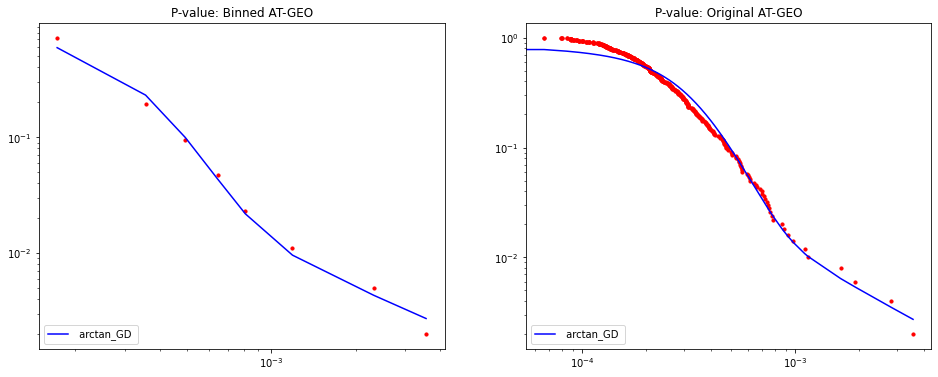

small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
curve_fit parameter on  arctan_GD :  [ 0.61737669  2.89432205 -0.06299162]
P-val Error at the furthest tail of Binned Y:  -0.0035609367653137713
P-val Error at the furthest tail of Original Y:  -0.0035609367653137713


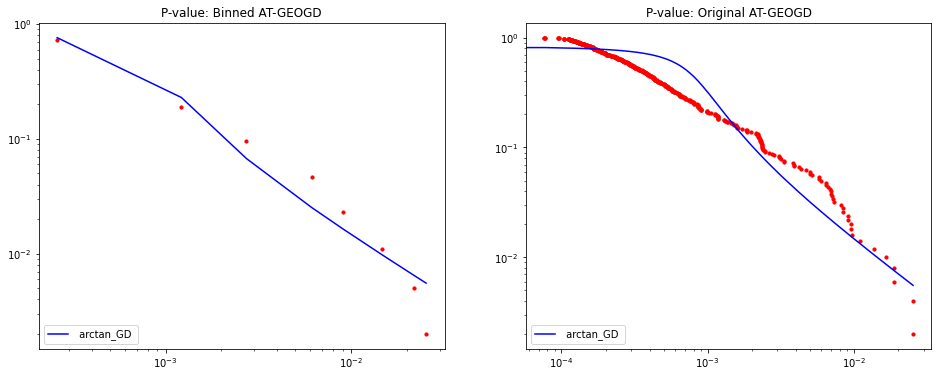

small-to-large nBins:  [188, 32, 16, 8, 4, 2, 1]
curve_fit parameter on  arctan_GD :  [0.60139633 0.6283041  0.95052082]
P-val Error at the furthest tail of Binned Y:  -0.0025653227349951013
P-val Error at the furthest tail of Original Y:  -0.0025653227349951013


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


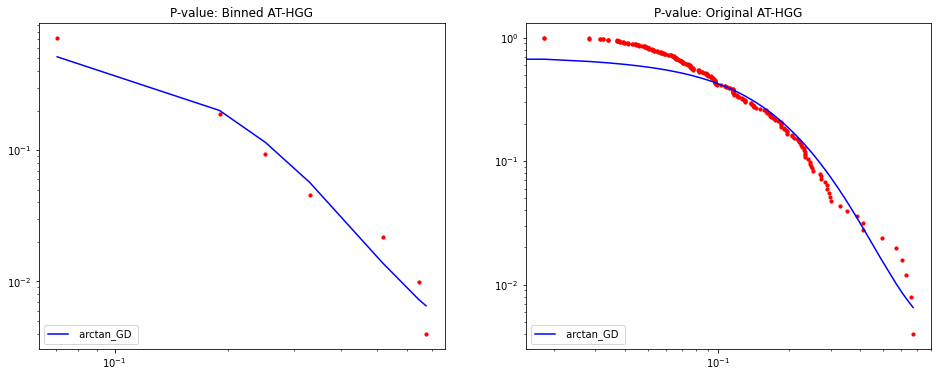

small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
curve_fit parameter on  arctan_GD :  [0.88061632 1.45175091 0.9396769 ]
P-val Error at the furthest tail of Binned Y:  -0.00016536532093125444
P-val Error at the furthest tail of Original Y:  -0.00016536532093125444


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


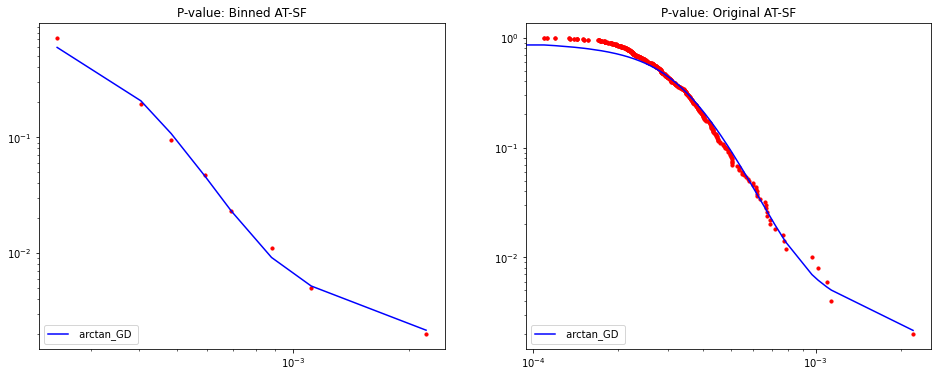

small-to-large nBins:  [373, 64, 32, 16, 8, 4, 2, 1]
curve_fit parameter on  arctan_GD :  [0.55426579 0.74403497 0.84873178]
P-val Error at the furthest tail of Binned Y:  -0.0013163263586040141
P-val Error at the furthest tail of Original Y:  -0.0013163263586040141


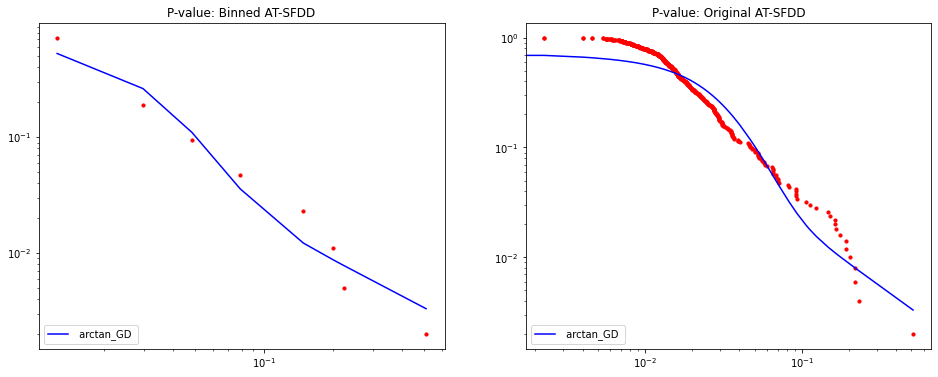

small-to-large nBins:  [372, 64, 32, 16, 8, 4, 2, 1]
curve_fit parameter on  arctan_GD :  [0.91182549 1.65273554 0.98232477]
P-val Error at the furthest tail of Binned Y:  -0.0002547872062389489
P-val Error at the furthest tail of Original Y:  -0.0002547872062389489


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: invalid value encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)


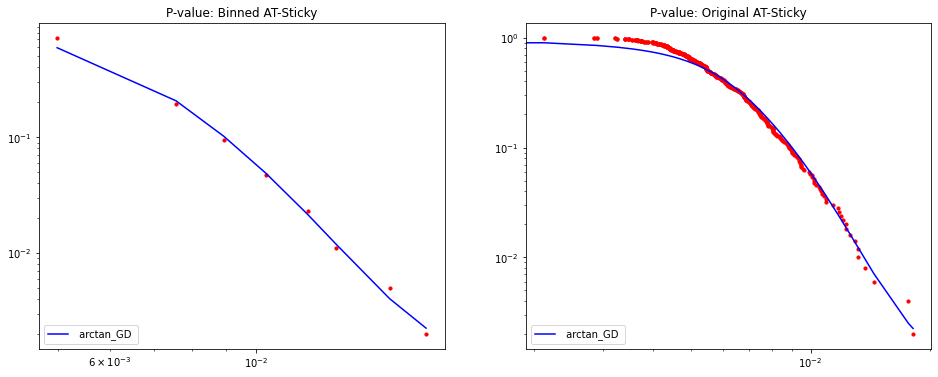

In [30]:
for i in range(len(Classes[:-1])):
    data_i = data_distance(data(df_AT,Classes[:-1][i]))
    factor = get_factor(data_i)
    sigmoid_to_ori(data_i,"AT", Classes[:-1][i],factor,arctan_GD, "Weight", "exp")

## fitting with factor, equal-sized bin

In [22]:
# same number of points in each bin
def data_binning(data):
    
    x,y = empirical_CDF(data)
    x = x[1:]
    y = y[1:]
    N = len(x)                   # e.g N = 500, sqrt(500)=22.3
    lower = int(np.floor(np.sqrt(N))) # 22
    upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
    
    if lower*upper >= N:
        small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
        small_bin_size = int(lower - 1)  # 21
        large_bin_size = lower
    else: # HGG -> sqrt(252) = 15.8
        small_bin_num = int(upper**2 - N) # 16*16-252 =4
        small_bin_size = lower  # 15
        large_bin_size = upper
    
    large_bin_num = int(upper - small_bin_num) # 23-6 = 17

    # small_bin_size*small_bin_num + lower*large_bin_num = N

    bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
    print("items in each bin: ", bin_count)
    binned_data = []
    binned_y = []
    i = 0
    for count in bin_count:
        binned_data.append(scipy.stats.mstats.gmean(x[i:i+count]))
        binned_y.append(scipy.stats.mstats.gmean(y[i:i+count]))
        i += count
    #print("binned_data: ",binned_data)
    return np.array(binned_data),np.array(binned_y)

Factor for AT-ER: 6.715204121812156e-05
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [0.41353547 0.93208151]
curve_fit parameter on  tanh :  [0.41354618 0.46604297]
curve_fit parameter on  arctan :  [0.73579731 3.70879064]
curve_fit parameter on  GD :  [0.47536797 0.43298899]
curve_fit parameter on  ERF :  [0.70633879 1.00000002]
curve_fit parameter on  arctan_GD :  [0.73569891 2.93563787 0.21259801]
curve_fit parameter on  Gompertz :  [0.09712717 0.89019934]


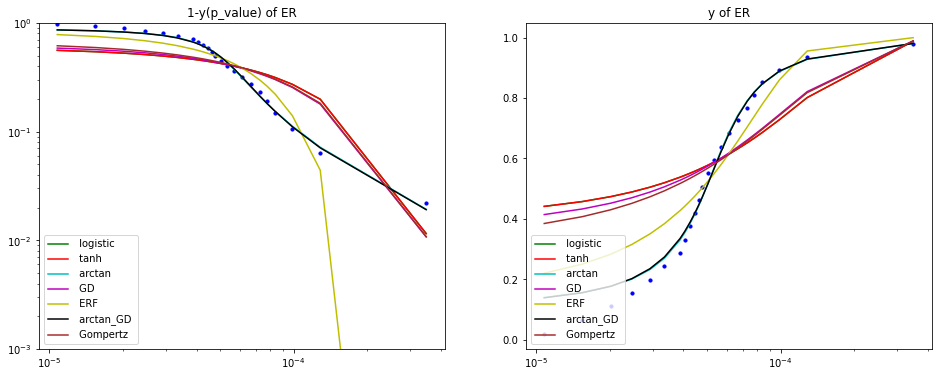

Factor for AT-ERDD: 0.012400372318699539
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [0.73011399 1.64605665]
curve_fit parameter on  tanh :  [0.73011986 0.82303197]
curve_fit parameter on  arctan :  [0.86870436 3.54432409]
curve_fit parameter on  GD :  [0.75902071 0.74202215]
curve_fit parameter on  ERF :  [0.66792258 0.57376827]
curve_fit parameter on  arctan_GD :  [0.84961915 1.38321457 0.74655522]
curve_fit parameter on  Gompertz :  [0.79543817 1.51292482]


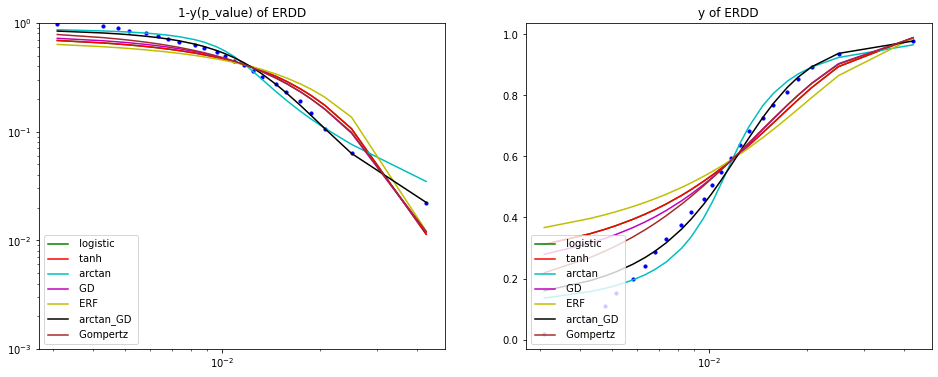

Factor for AT-GEO: 0.0002741471577618578
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [0.68583275 1.52362152]
curve_fit parameter on  tanh :  [0.68583032 0.76180895]
curve_fit parameter on  arctan :  [0.81608501 3.57328212]
curve_fit parameter on  GD :  [0.71544834 0.6898936 ]
curve_fit parameter on  ERF :  [0.62183818 0.52922257]
curve_fit parameter on  arctan_GD :  [0.80945973 1.6304119  0.63110618]
curve_fit parameter on  Gompertz :  [0.66826715 1.41357693]


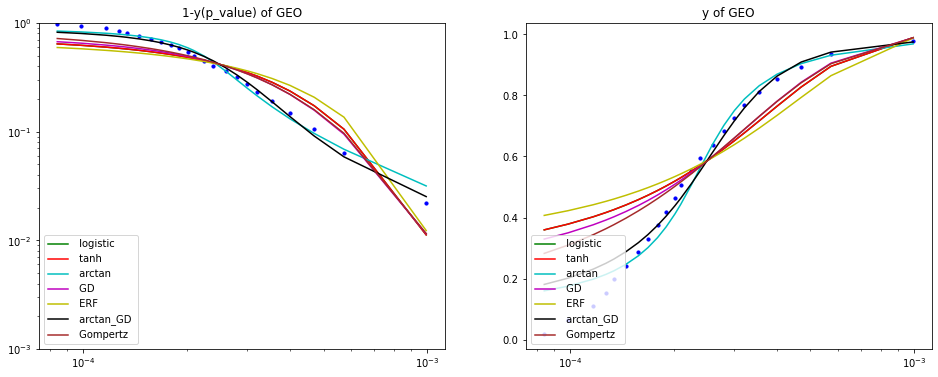

Factor for AT-GEOGD: 0.0011721805161020143
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [-0.03854318  0.48574899]
curve_fit parameter on  tanh :  [-0.03852951  0.2428752 ]
curve_fit parameter on  arctan :  [0.36512587 2.01207589]
curve_fit parameter on  GD :  [0.06272051 0.22316542]
curve_fit parameter on  ERF :  [0.30217549 1.        ]
curve_fit parameter on  arctan_GD :  [ 0.36510505  2.03034719 -0.00885962]
curve_fit parameter on  Gompertz :  [-0.30462047  0.45853461]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/2496000139.py:4: RuntimeWarning: divide by zero encountered in log
  return np.log(1-func(xdata, *params)) - np.log(1-ydata)
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_4788/4119179839.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


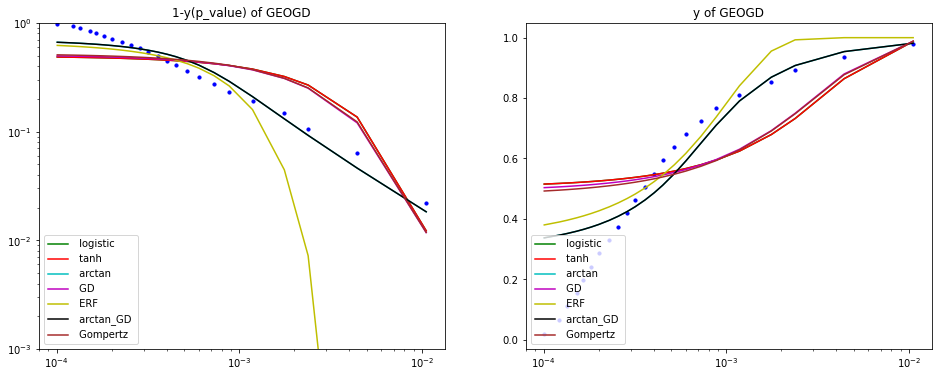

Factor for AT-HGG: 0.12493993663689285
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [0.71921186 1.42649081]
curve_fit parameter on  tanh :  [0.71921474 0.71324682]
curve_fit parameter on  arctan :  [0.78673665 2.67143327]
curve_fit parameter on  GD :  [0.7386194  0.63183612]
curve_fit parameter on  ERF :  [0.67884718 0.5234804 ]
curve_fit parameter on  arctan_GD :  [0.79287242 1.14013557 0.68708257]
curve_fit parameter on  Gompertz :  [0.59726138 1.29135212]


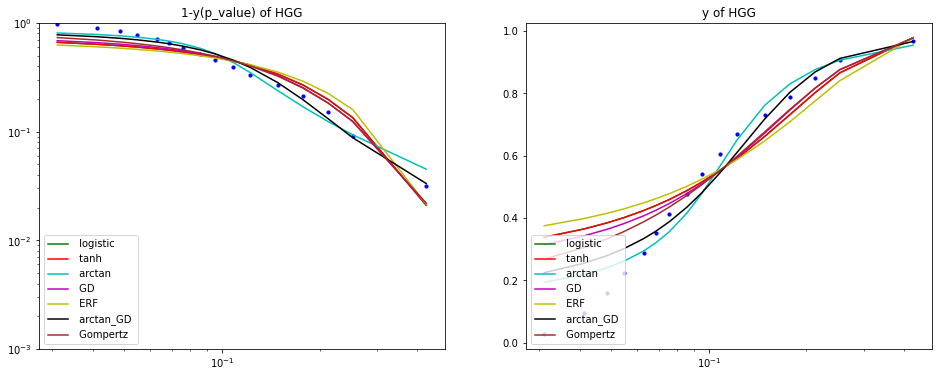

Factor for AT-SF: 0.00031738143836614616
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [0.85501257 2.73503036]
curve_fit parameter on  tanh :  [0.85501467 1.36751908]
curve_fit parameter on  arctan :  [0.9318579  5.37413679]
curve_fit parameter on  GD :  [0.87088423 1.2218933 ]
curve_fit parameter on  ERF :  [0.81951663 0.96930766]
curve_fit parameter on  arctan_GD :  [0.91534546 1.96847236 0.78967915]
curve_fit parameter on  Gompertz :  [1.79575824 2.48011215]


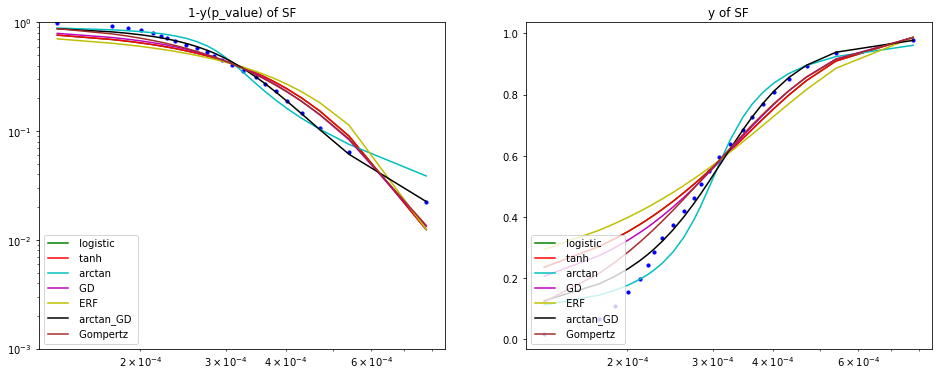

Factor for AT-SFDD: 0.025503546940582315
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [0.34978624 0.79207308]
curve_fit parameter on  tanh :  [0.34980225 0.39603886]
curve_fit parameter on  arctan :  [0.6442008  2.93734763]
curve_fit parameter on  GD :  [0.41731015 0.36593131]
curve_fit parameter on  ERF :  [0.22666763 0.27125326]
curve_fit parameter on  arctan_GD :  [ 6.44191763e-01  2.94592350e+00 -2.83715829e-03]
curve_fit parameter on  Gompertz :  [-0.01518123  0.75223745]


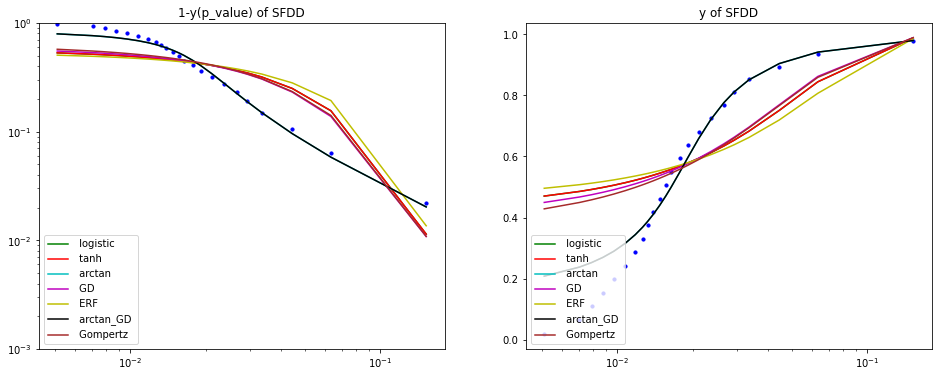

Factor for AT-Sticky: 0.00607303666770087
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [0.91254439 3.70014978]
curve_fit parameter on  tanh :  [0.91254483 1.85007633]
curve_fit parameter on  arctan :  [0.95472208 6.44390107]
curve_fit parameter on  GD :  [0.92165123 1.6311157 ]
curve_fit parameter on  ERF :  [0.89088213 1.3504929 ]
curve_fit parameter on  arctan_GD :  [0.93983509 2.14447375 0.85832188]
curve_fit parameter on  Gompertz :  [2.65157532 3.28973414]


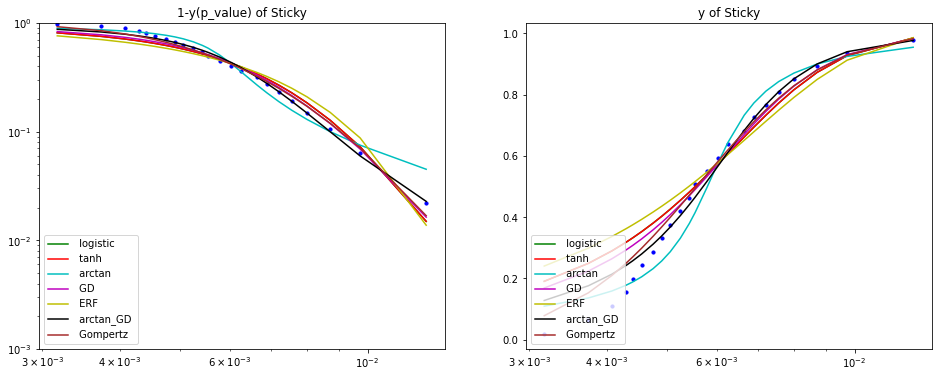

In [23]:
for i in range(len(Classes[:-1])):
    data_i = data_distance(data(df_AT,Classes[:-1][i]))
    factor = get_factor(data_i)
    print("Factor for {}-{}: {}".format("AT",Classes[:-1][i],factor))
    sigmoids_for_class_F(data_i, Classes[:-1][i], factor, functions, colors, "size")

### arctan_GD vs original data, fitting with equal-sized bin + factor

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
curve_fit parameter on  arctan_GD :  [0.73569891 2.93563787 0.21259801]
P-val Error at the furthest tail of Binned Y:  0.002943821617026998
P-val Error at the furthest tail of Original Y:  -0.001236360945678694


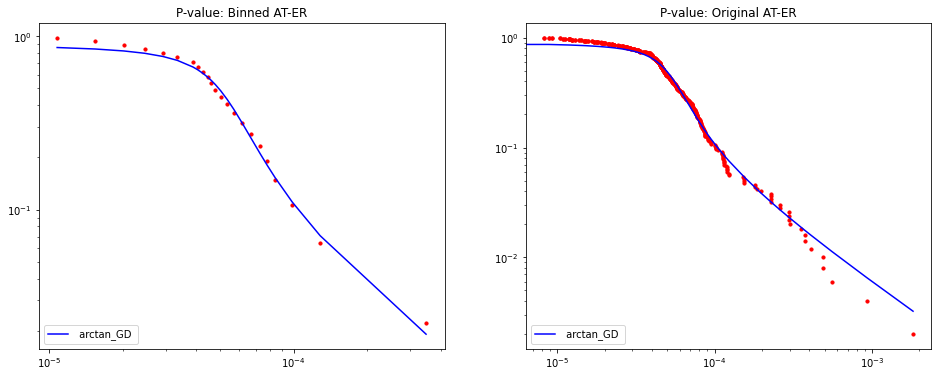

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
curve_fit parameter on  arctan_GD :  [0.84961915 1.38321457 0.74655522]
P-val Error at the furthest tail of Binned Y:  -0.00026122039735676506
P-val Error at the furthest tail of Original Y:  -0.004115744804658039


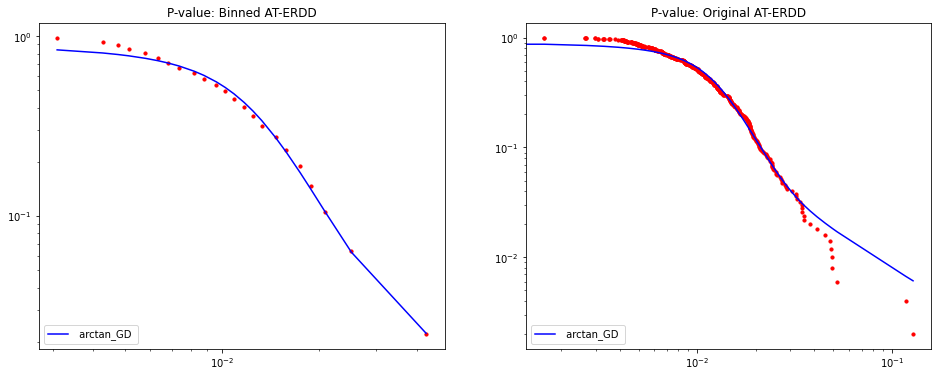

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
curve_fit parameter on  arctan_GD :  [0.80945973 1.6304119  0.63110618]
P-val Error at the furthest tail of Binned Y:  -0.003147079683921583
P-val Error at the furthest tail of Original Y:  -0.0038950471437749767


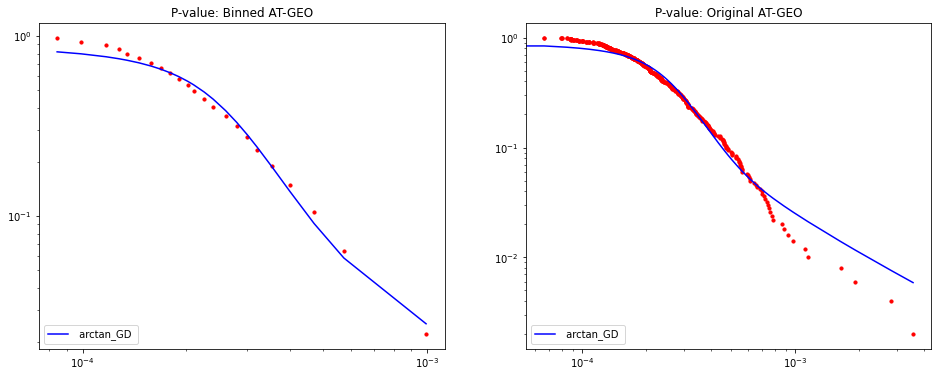

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
curve_fit parameter on  arctan_GD :  [ 0.36510505  2.03034719 -0.00885962]
P-val Error at the furthest tail of Binned Y:  0.003738902891127438
P-val Error at the furthest tail of Original Y:  -0.0054324350057110005


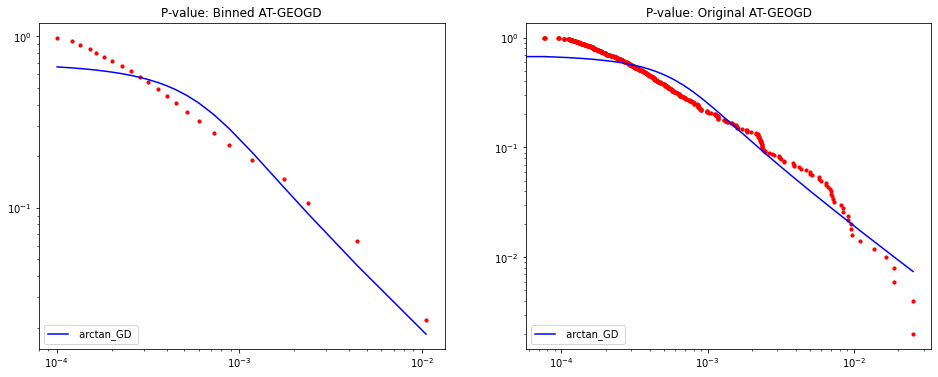

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
curve_fit parameter on  arctan_GD :  [0.79287242 1.14013557 0.68708257]
P-val Error at the furthest tail of Binned Y:  -0.0014042936034484033
P-val Error at the furthest tail of Original Y:  -0.01483002630207475


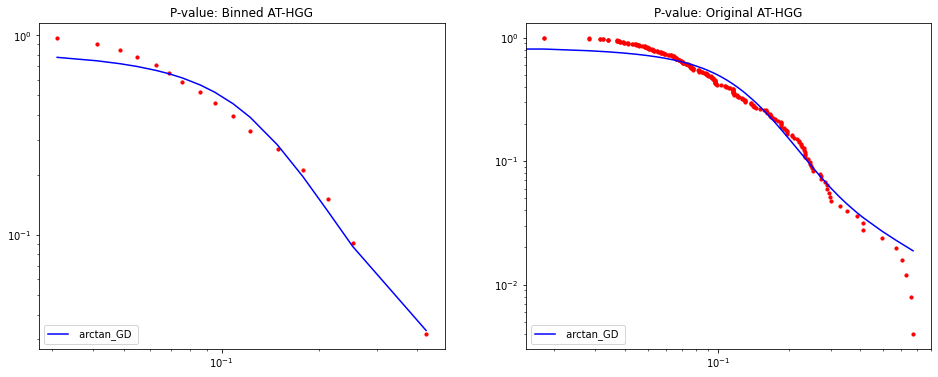

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
curve_fit parameter on  arctan_GD :  [0.91534546 1.96847236 0.78967915]
P-val Error at the furthest tail of Binned Y:  -0.0004438540475467656
P-val Error at the furthest tail of Original Y:  -0.0036105446826563137


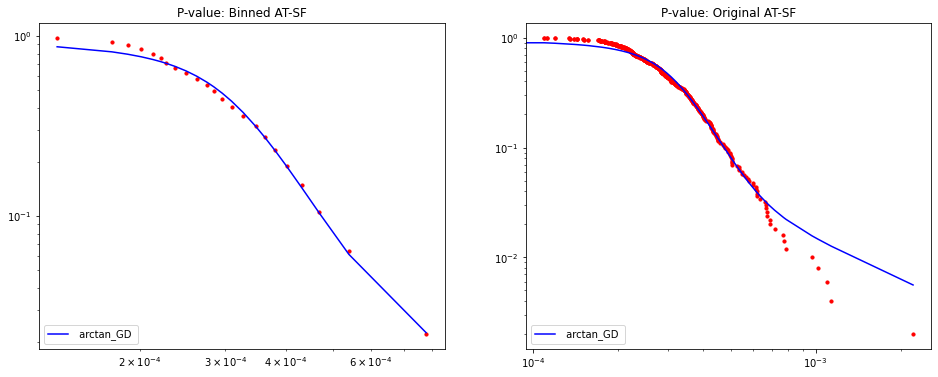

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
curve_fit parameter on  arctan_GD :  [ 6.44191763e-01  2.94592350e+00 -2.83715829e-03]
P-val Error at the furthest tail of Binned Y:  0.0017667846775394347
P-val Error at the furthest tail of Original Y:  -0.00358402899931487


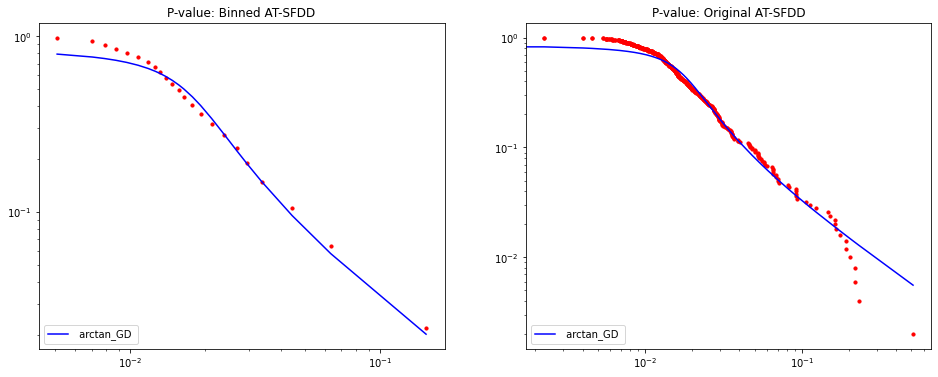

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
curve_fit parameter on  arctan_GD :  [0.93983509 2.14447375 0.85832188]
P-val Error at the furthest tail of Binned Y:  -0.0007117000185486999
P-val Error at the furthest tail of Original Y:  -0.008188283651831108


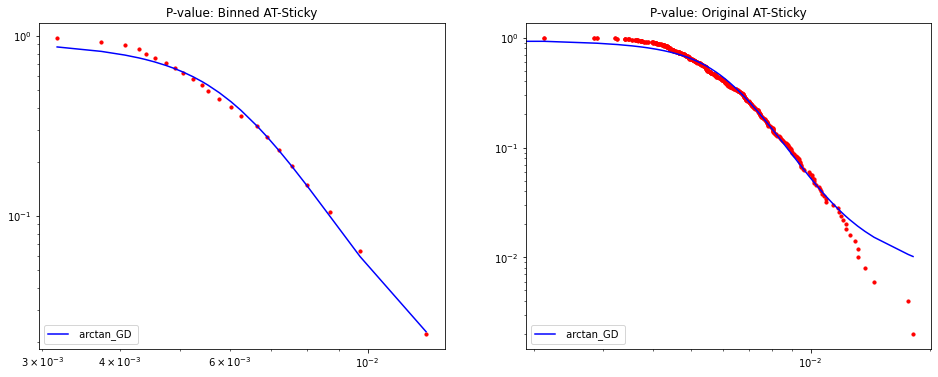

In [31]:
for i in range(len(Classes[:-1])):
    data_i = data_distance(data(df_AT,Classes[:-1][i]))
    factor = get_factor(data_i)
    sigmoid_to_ori(data_i,"AT", Classes[:-1][i],factor,arctan_GD,"Weight", "size")